In [1]:
%matplotlib inline

import datetime
import pandas as pd
import matplotlib.pyplot as plt
import plotly.plotly as py
import time

from sklearn import neural_network

from sklearn.metrics import mean_squared_error
from math import sqrt

timeformat = "%Y-%m-%d %H:%M:%S"

# Select feature

In [2]:
pm25 = pd.read_csv("../data/dropna/dropna.csv", parse_dates=True)[['PM2.5']]
pm25.columns = ["PM25"]

In [3]:
date_feature = pd.read_csv("../data/dropna/date_feature.csv", parse_dates=True)
#hour = ['hour_'+str(x) for x in range(24)]

#date_feature = date_feature[[f for f in date_feature.columns.tolist() if f in hour or f == "datetime"]]

In [4]:
time_series = pd.read_csv("../data/dropna/timeseries.csv", parse_dates=True)
lags = 12
time_series = time_series[['t-'+str(x+1) for x in range(lags)]]

In [5]:
dlt_series = pd.read_csv("../data/dropna/dlt_timeseries.csv", parse_dates=True)
lags = 3
dlt_series = dlt_series[['dlt-'+str(x+1) for x in range(lags)]]

In [6]:
meteorology = pd.read_csv("../data/dropna/separation.csv", parse_dates=True)
meteorology = meteorology[["AMB_TEMP", "RAINFALL", "RH", "WIND_SPEED"]]

In [7]:
## to forecast PM2.5(t), we use RAINFALL(t-1) instead of RAINFALL(t)
## cause we could not know RAINFALL(t) from weather forecast
meteorology.RAINFALL = meteorology.RAINFALL.shift()

In [ ]:
## Normalizeing meteorology data set
#meteorology = (meteorology - meteorology.min()) / (meteorology.max() - meteorology.min())
#meteorology = (meteorology - meteorology.mean()) / meteorology.std()
#meteorology = meteorology / meteorology.sum()
meteorology.head()

In [8]:
data = pd.concat([pm25, meteorology, time_series, date_feature], axis=1)

target = "PM25"
exclude = ['datetime', target]
features = [f for f in data.columns if f not in exclude]
feature_size = len(features)

In [9]:
print features

['AMB_TEMP', 'RAINFALL', 'RH', 'WIND_SPEED', 't-1', 't-2', 't-3', 't-4', 't-5', 't-6', 't-7', 't-8', 't-9', 't-10', 't-11', 't-12', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']


# Train & Test Split

In [75]:
TestStart = '2016-08-05 00:00:00'
TestEnd = '2016-08-07 00:00:00'

trainstart = data[data.datetime.values == '2014-01-01 00:00:00'].index[0]
start = data[data.datetime.values == TestStart].index[0]
end = data[data.datetime.values == TestEnd].index[0]

#train = pd.concat([data[:start], data[end:]], axis=0).dropna()
train = data[trainstart:start].dropna()
test = data[start:end].dropna()

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

datetime = data.datetime[start:end]

# Model

In [76]:
start_time = time.time()

MLP = neural_network.MLPRegressor(activation='relu')
MLP.fit(X_train, y_train)
#print 'Model: \n', MLP

predict = MLP.predict(X_test)

end_time = time.time()
print "Time consume: ", end_time - start_time, ' s.'

rmse = sqrt(mean_squared_error(predict, y_test))
print 'rmse : ', rmse

Time consume:  2.16917109489  s.
rmse :  3.68749715305


# Plot

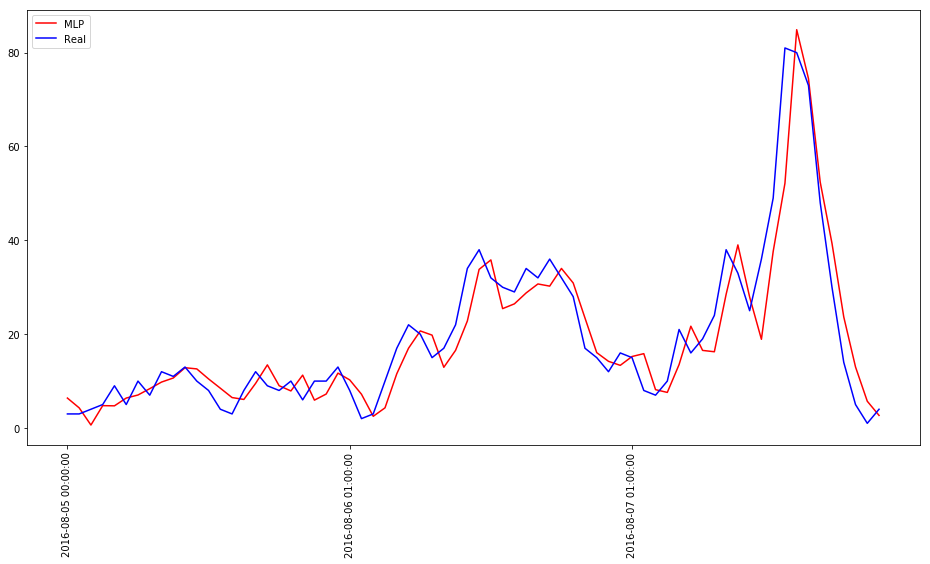

In [12]:
plt.rcParams['figure.figsize'] = [16.0, 8.0]

plt.plot(predict, "r", label="MLP")
plt.plot(y_test.tolist(), "b", label="Real")
plt.xticks(range(0,len(datetime),24), datetime[::24])
plt.xticks(rotation=90)
plt.legend(loc='upper left')
plt.show()

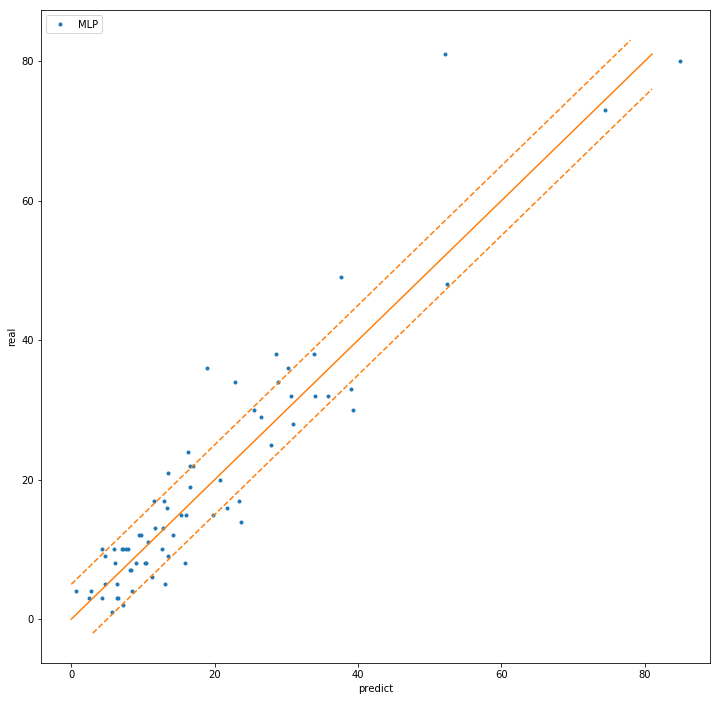

In [13]:
plt.rcParams['figure.figsize'] = [12.0, 12.0]

plt.xlabel('predict')
plt.ylabel('real')

plt.plot(predict, y_test.tolist(), "C0.", label="MLP")

a, b = 0, max(max(y_test.tolist()), 24)
mrange = 5
plt.plot([a, b], [a, b], 'C1-')
plt.plot([a, b - 3], [a+mrange, b+mrange -3], 'C1--')
plt.plot([a + 3, b], [a-mrange + 3, b-mrange], 'C1--')
    
plt.legend(loc='upper left')
plt.show()

In [14]:
threshold = [5, 10]


zipped = zip(y_test.tolist(), predict)
for t in threshold:
    count = 0
    for r, v in zipped:
        if abs(r - v) < t:
            count = count+1
    print "Threshold(%d), Proportion :"%(t), str(100.0 * count / len(predict))



Threshold(5), Proportion : 70.0
Threshold(10), Proportion : 94.2857142857


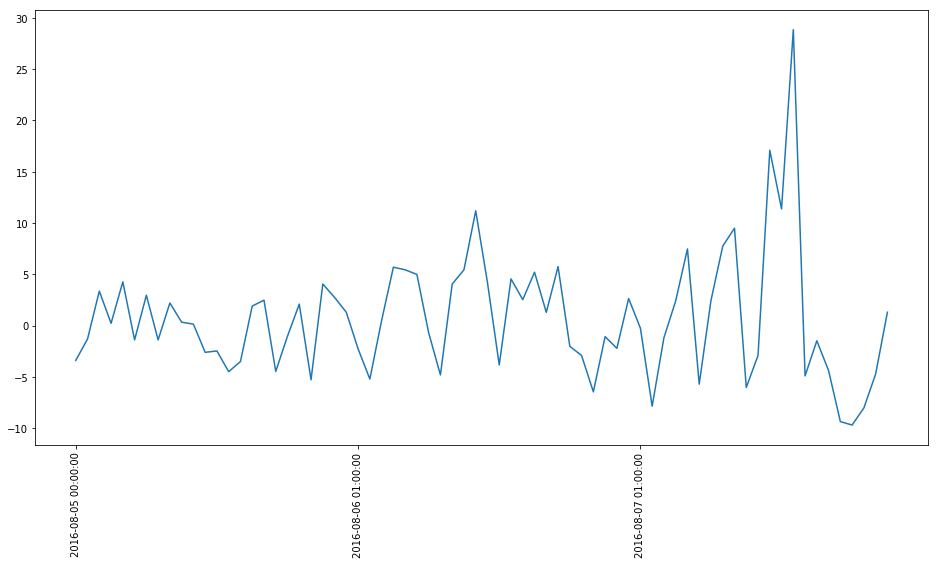

In [15]:
plt.rcParams['figure.figsize'] = [16.0, 8.0]
diff = [p - r for p, r in zipped]
plt.plot(diff, '-')
plt.xticks(range(0,len(datetime),24), datetime[::24])
plt.xticks(rotation=90)
plt.show()

In [16]:
print ("'2016-06-01 ~ 2016-07-31' Missind Data : %f %%")%(100.0*(1.0 - len(predict)/(61.0*24)))

'2016-06-01 ~ 2016-07-31' Missind Data : 95.218579 %
